In [503]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

# Загружаем выборку Diamonds

1. PRICE: price in US dollars (326-18,823)
2. CARAT: weight of the diamond (0.2--5.01)
3. CUT: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
4. COLOR: diamond colour, from J (worst) to D (best)
5. CLARITY: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
6. X: length in mm (0--10.74)
7. Y: width in mm (0--58.9)
8. Z: depth in mm (0--31.8)
9. DEPTH: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
10. TABLE: width of top of diamond relative to widest point (43--95)

In [504]:
diamonds_df = pd.read_csv('diamonds.csv')

In [505]:
diamonds_df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


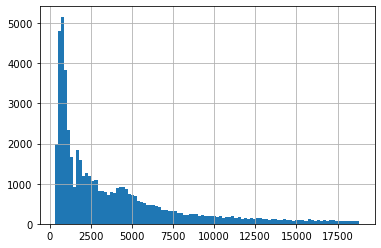

In [506]:
plt.hist(diamonds_df['price'], bins=100)
plt.grid();

# Подготовка данных

In [507]:
features = ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']
target = ['price']

In [508]:
cut_transform = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
clarity_transform = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}
color_transorm = {'D': 0, 'E': 1, 'F': 2, 'G': 3, 'H': 4, 'I': 5, 'J': 6}

In [509]:
diamonds_df['cut'] = diamonds_df['cut'].apply(lambda x: cut_transform.get(x))
diamonds_df['color'] = diamonds_df['color'].apply(lambda x: color_transorm.get(x))
diamonds_df['clarity'] = diamonds_df['clarity'].apply(lambda x: clarity_transform.get(x))

In [510]:
diamonds_df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,4,1,1,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,3,1,2,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,1,1,4,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,3,5,3,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,1,6,1,63.3,58.0,335,4.34,4.35,2.75


In [511]:
X = diamonds_df[features].copy().values
y = diamonds_df[target].values

In [512]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [513]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=47, test_size=0.3)

# Обучаем модель линейной регрессии

In [514]:
reg = LinearRegression().fit(X_train, y_train)

In [515]:
y_pred = reg.predict(X_test)

In [516]:
score = r2_score(y_pred, y_test)

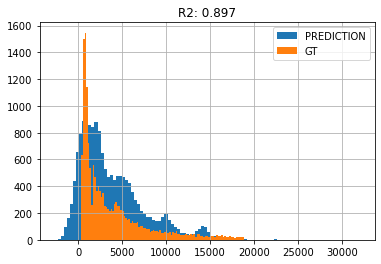

In [517]:
plt.title(f'R2: {str(score)[:5]}')
plt.hist(y_pred, bins=100, label='PREDICTION')
plt.hist(y_test, bins=100, label='GT')
plt.legend()
plt.grid()

# Создаём модель MLP для задачи регрессии

In [519]:
class MLPRegressor:
    def __init__(
            self,
            hidden_layer_sizes=(100,),
            learning_rate=0.001,
            max_iter=10,
            batch_size=32,
        ):
            self.hidden_layer_sizes = hidden_layer_sizes
            self.learning_rate = learning_rate
            self.max_iter = max_iter
            self.batch_size = batch_size
            self.loss_array = []

    def activate(self, t):
        # return 1 / (1 + np.exp(-t))
        return np.maximum(t, 0)

    def loss(self, y_pred, y):
        return (y - y_pred) ** 2

    def initialize_weights(self, input_size, output_size):
        # return np.random.randn(input_size, output_size)
        std_dev = np.sqrt(2 / (input_size + output_size))
        return np.random.randn(input_size, output_size) * std_dev

    def train(self, X, y):
        self.loss_array = []
        iters = X.shape[0]
        input_size = X.shape[1]
        output_size = y.shape[1]

        hidden_layer_sizes = [input_size] + list(self.hidden_layer_sizes) + [output_size]
        weights = []
        biases = []

        for i in range(len(hidden_layer_sizes) - 1):
            w = self.initialize_weights(hidden_layer_sizes[i], hidden_layer_sizes[i + 1])
            b = np.random.randn(1, hidden_layer_sizes[i + 1])
            weights.append(w)
            biases.append(b)

        num_batches = iters // self.batch_size

        for i in range(self.max_iter):
            random_indices = np.arange(iters)
            np.random.shuffle(random_indices)

            for batch_idx in range(num_batches):
                start = batch_idx * self.batch_size
                end = start + self.batch_size
                batch_indices = random_indices[start:end]

                batch_X = X[batch_indices]
                batch_y = y[batch_indices]

                activations = [batch_X]
                for j in range(len(self.hidden_layer_sizes) + 1):
                    t = activations[j] @ weights[j] + biases[j]
                    h = self.activate(t)
                    activations.append(h)

                y_pred = activations[-1]
                error = self.loss(y_pred, batch_y)
                self.loss_array.append(error.mean())

                gradients = [-2 * (batch_y - y_pred) / self.batch_size]
                for j in range(len(self.hidden_layer_sizes), -1, -1):
                    grad_t = gradients[-1]
                    grad_w = activations[j].T @ grad_t
                    grad_b = np.sum(grad_t, axis=0, keepdims=True)
                    grad_h = grad_t @ weights[j].T
                    grad_t = grad_h * (activations[j] > 0)
                    gradients.append(grad_t)

                    weights[j] -= self.learning_rate * grad_w
                    biases[j] -= self.learning_rate * grad_b

            # Проверяем условие завершения обучения
            if i % 500 == 0:
                print(f"Iteration: {i}, Loss: {np.mean(self.loss_array[-num_batches:])}")

            if self.loss_array[1] <= 0.2:
                print(f"Iteration: {i}, Loss: {np.mean(self.loss_array[-num_batches:])}")
                break  # Выход из цикла, если достигнуто условие
            
        self.weights = weights
        self.biases = biases


    def predict(self, X):
        activations = [X]
        for j in range(len(self.hidden_layer_sizes) + 1):
            t = activations[j] @ self.weights[j] + self.biases[j]
            h = self.activate(t)
            activations.append(h)
        
        y_pred = activations[-1]
        return y_pred

# Проверяем модель MLP на выборке Diamonds

In [520]:
# mlp_reg = MLPRegressor(hidden_layer_sizes=(64, 48, 32, 24, 16, 8), learning_rate=0.00000001, max_iter=X_train.shape[0], epochs=100)
# mlp_reg = MLPRegressor(hidden_layer_sizes=(32,), learning_rate=0.0001, max_iter=2000, batch_size=X_train.shape[0]//16) # -352 и график убывающий
mlp_reg = MLPRegressor(hidden_layer_sizes=(3, ), learning_rate=0.0001, max_iter=4000, batch_size=800)

mlp_reg.train(X_train, y_train)

Iteration: 0, Loss: 18952007.595872942
Iteration: 500, Loss: 1030604.468884544
Iteration: 1000, Loss: 848133.7698288144
Iteration: 1500, Loss: 1164762.42724611
Iteration: 2000, Loss: 916915.8152989337
Iteration: 2500, Loss: 844006.9530468934
Iteration: 3000, Loss: 1024069.0035848676
Iteration: 3500, Loss: 1002379.2680617684


In [521]:
y_mlp_pred = mlp_reg.predict(X_train)
mlp_score = r2_score(y_mlp_pred, y_train)
mlp_score

0.94626123697138

In [522]:
y_mlp_pred = mlp_reg.predict(X_test)
mlp_score = r2_score(y_mlp_pred, y_test)
print(mlp_score)

0.9458813263435207


In [523]:
print(np.unique(y_mlp_pred))
print(y_train[1])

[  816.62221512   816.88477631   816.95332228 ... 24419.16149865
 25463.11205043 27016.22167298]
[17360]


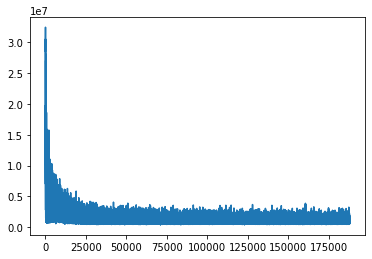

In [524]:
plt.plot(np.array(mlp_reg.loss_array).reshape(1, -1)[0])
plt.show()

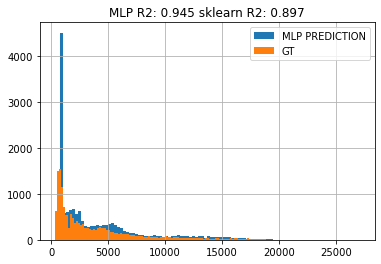

In [525]:
plt.title(f'MLP R2: {str(mlp_score)[:5]} sklearn R2: {str(score)[:5]}')
# plt.hist(y_pred, bins=100, label='sklearn PREDICTION')
plt.hist(y_mlp_pred, bins=100, label='MLP PREDICTION')
plt.hist(y_test, bins=100, label='GT')
plt.legend()
plt.grid()